# Detroit Blight Ticket

## 1-1-Summary
The Department of Administrative Hearings (DAH) is a major component of the City of Detroit's efforts to address blight in the city. Owener and tenant of properties are responsible for keeping their properties maintained according to the City of Detroit’s property maintenance code. If a property is not properly maintained inside and out, the residence may be issued a “Blight Ticket,” by City officials. [https://detroitmi.gov/departments/department-appeals-and-hearings/blight-ticket-information]

However, the compliance rate for these tickets is less than 10% of tickets where the homeowner is deemed responsible actually get paid, leaving some $70,000,000 in unpaid blight tickets over the past 12 years. [https://midas.umich.edu/wp-content/uploads/sites/3/2017/09/understanding-blight-ticket.pdf]

The aim of this project is to build a predictive model taht addresses ticket compliance.
The F1 score was the main metric that was used to compare the results with similar projects, although other metrics such as confusion matrix were reported. In addition the models were evaluated for overfitting by ...... .
Random Forrest, GBBoost, and were used for model traning.

## 1-2-Data set
The columns in the dataset and their definitions are as follow:
    Column names in dataset:
    
    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

# 2- Data Prepration

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn

In [3]:
# Importing data files:
train=pd.read_csv('data/train.csv',encoding='ISO-8859-1')
test= pd.read_csv('data/test.csv',encoding='ISO-8859-1')
train.set_index('ticket_id',inplace=True,drop=True)
test.set_index('ticket_id',inplace=True,drop=True)


address=pd.read_csv('data/addresses.csv',encoding='ISO-8859-1')
latlons=pd.read_csv('data/latlons.csv',encoding='ISO-8859-1')

C:\Users\Sepehr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (11,12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# preliminary data exploration
# After exploring features, the following features were eliminated due to potential data leakage problems:
# 'compliance_detail','payment_status', 'payment_date','payment_amount', 'balance_due'  

eliminated_features=['compliance_detail','payment_status', 'payment_date','payment_amount', 'balance_due','collection_status']

# Train Set

df_train=train.drop(train[eliminated_features], axis=1)

# The above columns are not in the test data set. Here, only a data frame is created for text data set
df_test=test


### Merging datasets

In [5]:
# Merging 'address.csv' and 'latlons.csv'
# Adding logitutde and latitude of propeties can help us to understand if the location is an important factor. 
address_latlons=pd.merge(address,latlons,how='left', left_on='address', right_on='address')

### Feature Engineering

In [6]:
# Definning bins for lon and lat
# The Detriot city will be divided to different region to see define and calculate 
# features based on region that a property is located. 
num_lats_bins=21 
num_lons_bins=21 

lat_bins=np.linspace(min(address_latlons['lat']),max(address_latlons['lat']),num_lats_bins)
lon_bins=np.linspace(min(address_latlons['lon']),max(address_latlons['lon']),num_lons_bins)


# Some zones have few records in. They usually are at the margins of the cities. We merged these zones together.

lat_bins=np.linspace(42.1882721,42.5906182,21).tolist()
lon_bins=np.linspace(min(address_latlons['lon']),max(address_latlons['lon']),15)
lat_bins.append(45.809387)
lat_bins.append(41.785926)
lat_bins=sorted(lat_bins)


In [7]:
lon_bins=np.linspace(-83.64382659,-82.83700446,19).tolist()
#lat_bins=[41.785926,lat_bins,45.809387]
lon_bins.append(-88.0813483)
lon_bins.append(-82.4335934)
lon_bins=sorted(lon_bins)


In [8]:
# Zoning lat:
address_latlons['zone_lat']=pd.cut(address_latlons['lat'], lat_bins, labels=False, retbins=False, right=False)

# Zoning lon:
address_latlons['zone_lon']=pd.cut(address_latlons['lon'], lon_bins, labels=False, retbins=False, right=False)


In [9]:
# Creating a mesh of regions based on the longitude and latitude
address_latlons['zone_lat']=address_latlons['zone_lat'].astype(str)
address_latlons['zone_lon']=address_latlons['zone_lon'].astype(str)
address_latlons['zone']=address_latlons['zone_lat'].str.cat(address_latlons['zone_lon'],sep='-')
address_latlons.set_index('ticket_id',inplace=True, drop= True)

In [10]:
# merging address_latlons with df_train and df_test sets:
train_address_latlons=pd.merge(df_train,address_latlons,how='left', left_index=True, right_index=True)
test_address_latlons=pd.merge(df_test,address_latlons,how='left', left_index=True, right_index=True)

df_train1= train_address_latlons
df_test1=test_address_latlons

In [11]:
# Exploring the features:
df_train1.describe()

,violation_street_number,violation_zip_code,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,lat,lon
count,2.503060e+05,0.0,2.467040e+05,250305.000000,250306.000000,250306.000000,250306.000000,250306.000000,250306.0,250306.000000,159880.000000,250303.000000,250303.000000
mean,1.064986e+04,NaN,9.149788e+03,374.423435,12.774764,6.387382,21.494506,0.125167,0.0,268.685356,0.072536,42.389139,-83.111452
std,3.188733e+04,NaN,3.602034e+04,707.195807,9.607344,4.803672,56.464263,3.430178,0.0,626.915212,0.259374,0.038240,0.094370
min,0.000000e+00,NaN,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,41.785926,-88.081348
25%,4.739000e+03,NaN,5.440000e+02,200.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,42.364044,-83.185490
50%,1.024400e+04,NaN,2.456000e+03,250.000000,20.000000,10.000000,10.000000,0.000000,0.0,140.000000,0.000000,42.392079,-83.123886
75%,1.576000e+04,NaN,1.292725e+04,250.000000,20.000000,10.000000,25.000000,0.000000,0.0,305.000000,0.000000,42.418848,-83.035374
max,1.415411e+07,NaN,5.111345e+06,10000.000000,20.000000,10.000000,1000.000000,350.000000,0.0,11030.000000,1.000000,45.809387,-82.433593


## 2-1- Missing Values

In [12]:
# Missing Values
# We get the unique values of each feature to see how informative they are:
#Exploring contetnt of features:
for col in list(df_train1.columns):
    print('\n Feature: {} \n\n{}' .format(col,df_train1[col].value_counts()))


 Feature: agency_name 

Buildings, Safety Engineering & Env Department    157784
Department of Public Works                         74717
Health Department                                   8903
Detroit Police Department                           8900
Neighborhood City Halls                                2
Name: agency_name, dtype: int64

 Feature: inspector_name 

Morris, John        17926
Steele, Jonathan    13237
Samaan, Neil J      12733
O'Neal, Claude      11591
Devaney, John       10769
                    ...  
Fisher, Rodney          1
YOUNG, GERALDINE        1
Doneghy, John           1
Walton, William         1
Johnson, James          1
Name: inspector_name, Length: 173, dtype: int64

 Feature: violator_name 

INVESTMENT, ACORN                     809
INVESTMENT CO., ACORN                 425
BANK, WELLS FARGO                     328
MILLER, JOHN                          205
SHIFMAN, ALLEN                        192
                                     ... 
MORTAGE CORP, MVB


 Feature: zone_lon 

12.0    51152
11.0    38532
10.0    36849
13.0    32062
15.0    28483
16.0    23428
14.0    20677
9.0     17365
17.0     1453
8.0       256
0.0        17
3.0        12
7.0         7
nan         4
19.0        4
5.0         3
6.0         1
4.0         1
Name: zone_lon, dtype: int64

 Feature: zone 

11.0-11.0    10372
10.0-12.0     9401
11.0-12.0     9020
10.0-11.0     9010
9.0-12.0      8887
             ...  
19.0-9.0         1
21.0-10.0        1
15.0-9.0         1
21.0-7.0         1
17.0-13.0        1
Name: zone, Length: 127, dtype: int64


In [13]:
# There are features with a large number of unique values. These feature can not help us to predict the ticket compliance.
# Also we do not need 'address', lat', 'lon', 'zone_lon', 'zone_lat', ''
# The following features will be eliminated: 'violator_name','violation_street_number','violation_street_name','mailing_address_str_number',
# 'mailing_address_str_name','zip_code', 'country', 'address', 'lat', 'lon', 'zone_lat', 'zone_lon'
eliminated_features=['violator_name','violation_street_number','violation_street_name','mailing_address_str_number',
 'mailing_address_str_name','zip_code', 'country', 'address', 'lat', 'lon', 'zone_lat', 'zone_lon']

# Train data Set
df_train1=df_train1.drop(eliminated_features, axis=1,errors='ignore')

# Test data set
df_test1=df_test1.drop(eliminated_features, axis=1,errors='ignore')


In [14]:
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250306 entries, 22056 to 325561
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   agency_name            250306 non-null  object 
 1   inspector_name         250306 non-null  object 
 2   violation_zip_code     0 non-null       float64
 3   city                   250306 non-null  object 
 4   state                  250213 non-null  object 
 5   non_us_str_code        3 non-null       object 
 6   ticket_issued_date     250306 non-null  object 
 7   hearing_date           237815 non-null  object 
 8   violation_code         250306 non-null  object 
 9   violation_description  250306 non-null  object 
 10  disposition            250306 non-null  object 
 11  fine_amount            250305 non-null  float64
 12  admin_fee              250306 non-null  float64
 13  state_fee              250306 non-null  float64
 14  late_fee               250306 no

In [15]:
# Missin Values
# Eliminating Features with large number of missing value:
# As can be seen from above, the following columns have a lot of missing value. 
# violation_zip_code, non_us_str_code, grafitti_status

eliminated_features=['violation_zip_code', 'non_us_str_code', 'grafitti_status']

# Train data Set
df_train1=df_train1.drop(df_train[eliminated_features], axis=1,errors='ignore')

# Test data set
df_test1=df_test1.drop(df_test[eliminated_features], axis=1,errors='ignore')

# state and hearing_date have some missing value, They are replaced with mode of each featurs:
state_mode=df_train1['state'].mode()
hearing_date_mode=df_train1['hearing_date'].mode()


df_train1['state'].fillna(df_train1['state'].mode()[0],inplace=True)
df_train1['hearing_date'].fillna(df_train1['hearing_date'].mode()[0],inplace=True)

df_train1.head()

,agency_name,inspector_name,city,state,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,zone
ticket_id,,,,,,,,,,,,,,,,,,
22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",CHICAGO,IL,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,11.0-12.0
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Detroit,MI,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,1.0,7.0-12.0
22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",DETROIT,MI,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10.0-13.0
22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",DETROIT,MI,2004-04-26 13:30:00,2005-12-22 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10.0-13.0
22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",DETROIT,MI,2004-04-26 13:00:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0-10.0


In [16]:
# Eliminating blight ticket with NaN value:
df_train1=df_train1[pd.notna(df_train1['compliance'])]
print('\n \nAfter eliminating some features and NaN in compliance feature:  \n ')
df_train1.head()


 
After eliminating some features and NaN in compliance feature:  
 


,agency_name,inspector_name,city,state,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,zone
ticket_id,,,,,,,,,,,,,,,,,,
22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",CHICAGO,IL,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,11.0-12.0
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Detroit,MI,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,1.0,7.0-12.0
22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",LOG BEACH,CA,2004-05-01 11:50:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,0.0-10.0
18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Clinton,MI,2004-06-14 14:15:00,2005-02-22 15:00:00,61-63.0500,Failed To Secure Permit For Lawful Use Of Land,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,13.0-14.0
18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Detroit,MI,2004-06-16 12:30:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,10.0-14.0


In [17]:
# All values in clean_up_cost are 0. This feature should be eliminated:
# violation_description and violation_code are the same. Violation_description will be eliminated.
eliminated_features=['clean_up_cost', 'violation_description']

# Train data Set
df_train1=df_train1.drop(df_train1[eliminated_features], axis=1)

# Test data set
df_test1=df_test1.drop(df_test1[eliminated_features], axis=1)



#df_train3=df_train3.reset_index()
#df_test1=df_test1[columns_test]
df_train1.head()

,agency_name,inspector_name,city,state,ticket_issued_date,hearing_date,violation_code,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,compliance,zone
ticket_id,,,,,,,,,,,,,,,,
22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",CHICAGO,IL,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Responsible by Default,250.0,20.0,10.0,25.0,0.0,305.0,0.0,11.0-12.0
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Detroit,MI,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,855.0,1.0,7.0-12.0
22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",LOG BEACH,CA,2004-05-01 11:50:00,2005-03-21 10:30:00,9-1-36(a),Responsible by Default,250.0,20.0,10.0,25.0,0.0,305.0,0.0,0.0-10.0
18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Clinton,MI,2004-06-14 14:15:00,2005-02-22 15:00:00,61-63.0500,Responsible by Default,750.0,20.0,10.0,75.0,0.0,855.0,0.0,13.0-14.0
18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Detroit,MI,2004-06-16 12:30:00,2005-02-22 15:00:00,61-63.0100,Responsible by Default,100.0,20.0,10.0,10.0,0.0,140.0,0.0,10.0-14.0


In [18]:
# Creating new features:
# Train data set  
    #in_city: if the a violator lives in Detroit
df_train1['city']=df_train1['city'].str.upper()
df_train1['in_city']=0
df_train1.loc[df_train1['city'] == 'DETROIT', 'in_city'] = 1
#df.loc[df['column name'] condition, 'new column name'] = 'value if condition is met'

    # in_state: if the violator lives in MI
df_train1['in_state']=0
df_train1.loc[df_train1['state'] == 'MI', 'in_state'] = 1


# test data set:
    #in_city: if the a violator lives in Detroit
df_test1['city']=df_test1['city'].str.upper()
df_test1['in_city']=0
df_test1.loc[df_test1['city'] == 'DETROIT', 'in_city'] = 1
#df.loc[df['column name'] condition, 'new column name'] = 'value if condition is met'

    # in_state: if the violator lives in MI
df_test1['in_state']=0
df_test1.loc[df_test1['state'] == 'MI', 'in_state'] = 1

In [19]:
   # 'violation_code'
# there are 189 unique violation codes in the data. Hiwever, the structure of the violation coding lets us to aggregate these codes. We considred the first two splits of
# the coding to recategrize violations. It gives us 33 violation categories.
    # train data set
xxx=df_train1['violation_code'].str.split('-', expand=True).iloc[:,:2]
xxx.columns=['0','1']
df_train1['violation_code_new']=xxx['0'].str.cat(xxx['1'], sep='-')

    # test data set
#### Note for test data set, we need to use the categorises that we defined based on train data set. if a violation code exist only in test data set, it will be ignored (considerd as Nan), since it was not in the our training model. 
xxx=df_test1['violation_code'].str.split('-', expand=True).iloc[:,:2]
xxx.columns=['0','1']
df_test1['violation_code_new']=xxx['0'].str.cat(xxx['1'], sep='-')
#df_test1=df_test1.merge(df_test1[['violation_code','violation_code_new']], left_on='violation_code', right_on='violation_code',how='left')
df_test1.columns

Index(['agency_name', 'inspector_name', 'city', 'state', 'ticket_issued_date',
       'hearing_date', 'violation_code', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'judgment_amount', 'zone', 'in_city', 'in_state', 'violation_code_new'],
      dtype='object')

In [20]:
# counting the number of violations of each types in each zone:
# Using crosstab we can create a table that shows how many of each violation occured in each zone. 

table=pd.crosstab(df_train1['zone'],df_train1['violation_code_new'])
table=table.reset_index()
table.head()

violation_code_new,zone,22-2,22-3,61-101.0100/32.0066,61-104.0100,61-111.0100/32.0066,61-114.0100,61-118.0100/32.0066,61-120.0100/32.0066,61-121.0100/32.0066,...,61-82.0100/32.0066,61-83.0100/32.0031,61-83.0100/32.0066,61-84.0100/32.0066,61-84.0100/45.0807,61-86.0100/32.0066,61-86.0100/32.0076B,61-86.0100/45.0807,61-90.0100,9-1
0,0.0-10.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0.0-11.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0-3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,10.0-10.0,1058,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3148
4,10.0-11.0,1412,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,4175


In [21]:
# Finding the number of each violations in zone that a ticket was issued:
# train data set:
df_train1=df_train1.merge(table, left_on='zone', right_on='zone',how='left')

# test data set:
df_test1=df_test1.merge(table, left_on='zone', right_on='zone',how='left')


### Handeling Date format

In [22]:
# Handeling Date format:
    # train data set:
# Changing 'hearing_date' , 'ticket_issued_date' and  to date format:
df_train1['ticket_issued_date'] = pd.to_datetime(df_train1['ticket_issued_date'])
df_train1['hearing_date'] = pd.to_datetime(df_train1['hearing_date'])

# The differenc between 'hearing_date' and 'ticket_issued_date':
df_train1['time_between_ticket_hearing']=(df_train1['hearing_date'] - df_train1['ticket_issued_date']).dt.components.iloc[:,0]

# finding the day 0f hearing date:
df_train1['weekday_hearing_date']=df_train1['hearing_date'].dt.dayofweek.astype(str)

# if the ticket as has discount
df_train1['has_discount']=1
df_train1.loc[df_train1['discount_amount'] == 0, 'has_discount'] = 0


    # test data set:
# Changing 'hearing_date' , 'ticket_issued_date' and  to date format:
df_test1['ticket_issued_date'] = pd.to_datetime(df_test1['ticket_issued_date'])
df_test1['hearing_date'] = pd.to_datetime(df_test1['hearing_date'])

# The differenc between 'hearing_date' and 'ticket_issued_date':
df_test1['time_between_ticket_hearing']=(df_test1['hearing_date'] - df_test1['ticket_issued_date']).dt.components.iloc[:,0]

# finding the day 0f hearing date:
df_test1['weekday_hearing_date']=df_test1['hearing_date'].dt.dayofweek.astype(str)

# if the ticket as has discount
df_test1['has_discount']=1
df_test1.loc[df_test1['discount_amount'] == 0, 'has_discount'] = 0





In [23]:
# After some feature engineering, some features that were used for creating new features should be eliminated:
'city', 'state','ticket_issued_date', 'hearing_date', 'violation_code', 'admin_fee', 'state_fee','discount_amount','collection_status'

eliminated_features=['city', 'state','ticket_issued_date', 'hearing_date', 'violation_code',
                     'admin_fee', 'state_fee','discount_amount']

# Train data Set
df_train1=df_train1.drop(df_train1[eliminated_features], axis=1)

# Test data set
df_test1=df_test1.drop(df_test1[eliminated_features], axis=1)



In [24]:
# Expolring target feature:
print ('percent of compliance ticket in target: {:.2f}' 
       .format(np.round(df_train1['compliance'].value_counts()[1]/len(df_train1),decimals=3)))
print ('percent of non-compliance ticket in target: {:.2f}' 
       .format(np.round(df_train1['compliance'].value_counts()[0]/len(df_train1),decimals=3)))
# the data set is unbalanced. 

percent of compliance ticket in target: 0.07
percent of non-compliance ticket in target: 0.93


In [25]:
df_train1.head()

,agency_name,inspector_name,disposition,fine_amount,late_fee,judgment_amount,compliance,zone,in_city,in_state,...,61-84.0100/32.0066,61-84.0100/45.0807,61-86.0100/32.0066,61-86.0100/32.0076B,61-86.0100/45.0807,61-90.0100,9-1,time_between_ticket_hearing,weekday_hearing_date,has_discount
0,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",Responsible by Default,250.0,25.0,305.0,0.0,11.0-12.0,0,0,...,0,0,0,0,0,2,4717,369,0,0
1,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Responsible by Determination,750.0,75.0,855.0,1.0,7.0-12.0,1,1,...,0,0,0,0,0,0,2017,378,4,0
2,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",Responsible by Default,250.0,25.0,305.0,0.0,0.0-10.0,0,0,...,0,0,0,0,0,0,2,323,0,0
3,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Responsible by Default,750.0,75.0,855.0,0.0,13.0-14.0,0,1,...,0,0,0,0,0,0,2485,253,1,0
4,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Responsible by Default,100.0,10.0,140.0,0.0,10.0-14.0,1,1,...,0,0,0,0,0,0,1174,251,1,0


### One-hot Encoding

In [26]:
# One-hot Encoding
# 'disposition' may be needed to be added again.
    # train data set
#df_train1=df_train1.set_index('ticket_id')
df_dummies= pd.DataFrame(data=pd.get_dummies(df_train1[['agency_name','inspector_name', 'zone','violation_code_new','disposition']]),index=df_train1.index)

df_train1=pd.merge(df_train1,df_dummies, how='left', left_index=True, right_index=True) 

# Droping the features that one hot encodes were created based on:
eliminated_features=['agency_name', 'inspector_name',  'zone', 'violation_code_new','disposition']
df_train1=df_train1.drop(df_train1[eliminated_features], axis=1,errors='ignore')


# Test data set
#df_test1=df_test1.set_index('ticket_id')
df_dummies= pd.DataFrame(pd.get_dummies(df_test1[['agency_name', 'inspector_name',  'zone', 'violation_code_new']]),index=df_test1.index)

df_test1=pd.merge(df_test1,df_dummies, how='left', left_index=True, right_index=True) 

# Droping the features that one hot encodes were created based on:
df_test1=df_test1.drop(df_test1[eliminated_features], axis=1,errors='ignore')


In [27]:
df_train1.head()

,fine_amount,late_fee,judgment_amount,compliance,in_city,in_state,22-2,22-3,61-101.0100/32.0066,61-104.0100,...,violation_code_new_61-84.0100/45.0807,violation_code_new_61-86.0100/32.0066,violation_code_new_61-86.0100/32.0076B,violation_code_new_61-86.0100/45.0807,violation_code_new_61-90.0100,violation_code_new_9-1,disposition_Responsible (Fine Waived) by Deter,disposition_Responsible by Admission,disposition_Responsible by Default,disposition_Responsible by Determination
0,250.0,25.0,305.0,0.0,0,0,1031,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,750.0,75.0,855.0,1.0,1,1,652,5,0,0,...,0,0,0,0,0,0,0,0,0,1
2,250.0,25.0,305.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,750.0,75.0,855.0,0.0,0,1,812,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,100.0,10.0,140.0,0.0,1,1,227,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# 3- Predictive Models

In [28]:
# Data transformation
import time
s=time.time()
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeClassifier


X=df_train1.iloc[:, df_train1.columns != 'compliance']
y=df_train1['compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Logistic Regression

C:\Users\Sepehr\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy validation set: 
0.794
Accuracy test set: 
0.798
Best parameter setting: 
{'clf__C': 1000}
Confusion matrix: 
[[48869    92]
 [ 3264   536]]
ROC_AUC: 
0.80


C:\Users\Sepehr\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


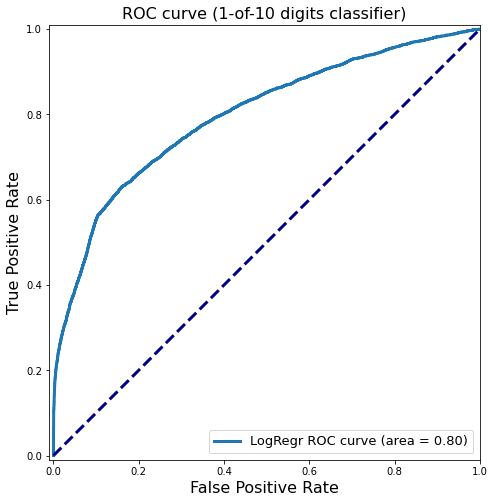

(52761,)
calculation_time: 
305.64962792396545
               precision    recall  f1-score   support

no compliance       0.94      1.00      0.97     48961
   compliance       0.85      0.14      0.24      3800

     accuracy                           0.94     52761
    macro avg       0.90      0.57      0.60     52761
 weighted avg       0.93      0.94      0.91     52761



In [30]:
# Logistic Regression
# The combination of GridSerchCV and Pipeline
# The important parameter for Logisticregressio is C. Pipeline and Gridsearch were run to find the best paramers setting. 

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
#param_grid={clf_C:[0.0001,0.001,0.1,10,1000]}
param_grid = dict(clf__C=[0.1,10,1000])

pipe=Pipeline([('scaler',MinMaxScaler()), ('clf',LogisticRegression())])

# Since we have a unbalanced sample, auc works beter to find the best model
grid=GridSearchCV(pipe,param_grid, cv=5,n_jobs=-1,scoring='roc_auc')
grid.fit(X_train,y_train)
print('Accuracy validation set: \n{:.3}' .format(grid.best_score_))

print('Accuracy test set: \n{:.3}' .format(grid.score(X_test,y_test)))
print('Best parameter setting: \n{}' .format(grid.best_params_))

predictions=grid.predict(X_test)
confusion=confusion_matrix(y_test,predictions)
print('Confusion matrix: \n{}'.format(confusion))

scores=grid.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc=auc(fpr, tpr)

print('ROC_AUC: \n{:.2f}' .format(roc_auc))

plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()
print(scores.shape)
e=time.time()

calculation_time1=e-s
print('calculation_time: \n{}'.format(calculation_time1))

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['no compliance', 'compliance']))

### Ridge Classifier

Accuracy validation set: 
0.793
Accuracy test set: 
0.797
Best parameter setting: 
{'clf__alpha': 0.1}
Confusion matrix: 
[[48910    51]
 [ 3374   426]]
ROC_AUC: 
0.80


C:\Users\Sepehr\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


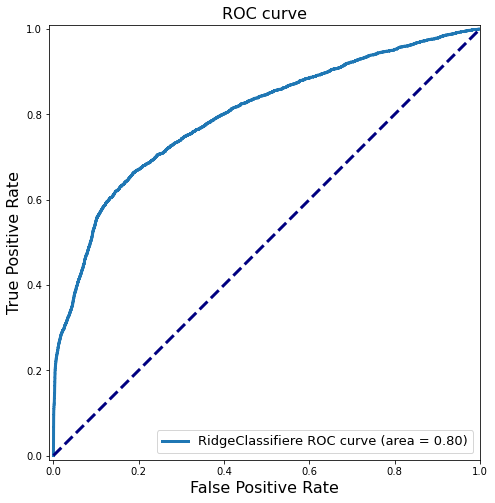

(52761,)
calculation_time: 
1451.9444324970245
               precision    recall  f1-score   support

no compliance       0.94      1.00      0.97     48961
   compliance       0.89      0.11      0.20      3800

     accuracy                           0.94     52761
    macro avg       0.91      0.56      0.58     52761
 weighted avg       0.93      0.94      0.91     52761



In [65]:

from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
#param_grid={clf_C:[0.0001,0.001,0.1,10,1000]}
param_grid = dict(clf__alpha=[0.1,10])

pipe=Pipeline([('scaler',MinMaxScaler()), ('clf',RidgeClassifier())])


# Since we have a unbalanced sample, auc works beter to find the best model
grid=GridSearchCV(pipe,param_grid, cv=5,n_jobs=-1,scoring='roc_auc')
grid.fit(X_train,y_train)
print('Accuracy validation set: \n{:.3}' .format(grid.best_score_))

print('Accuracy test set: \n{:.3}' .format(grid.score(X_test,y_test)))
print('Best parameter setting: \n{}' .format(grid.best_params_))

predictions=grid.predict(X_test)
confusion=confusion_matrix(y_test,predictions)
print('Confusion matrix: \n{}'.format(confusion))

scores=grid.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc=auc(fpr, tpr)

print('ROC_AUC: \n{:.2f}' .format(roc_auc))

plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='RidgeClassifiere ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()
print(scores.shape)
e=time.time()

calculation_time1=e-s
print('calculation_time: \n{}'.format(calculation_time1))

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['no compliance', 'compliance']))

Note that parameters from grid.cv_results can be used to draw Validation curve:
The mean_fit_time, std_fit_time, mean_score_time and std_score_time.
In the Next cell I use validation_curve to plot validation curve

#### Checking for Overfitting or Underfitting:

#### Validation Curve

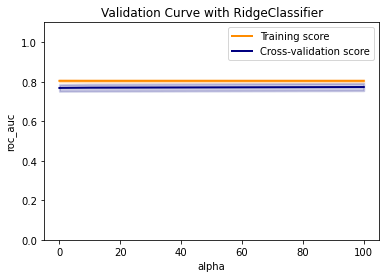

In [64]:
# Plotting Validation Curves:
from sklearn.model_selection import validation_curve
from sklearn.linear_model import RidgeClassifier
param_range=[0.0001,0.001,0.01, 0.1, 1, 10, 100]
#ridge=Ridge()
train_scores, test_scores = validation_curve(RidgeClassifier(), X, y, param_name="alpha",
param_range=param_range,cv=5, scoring='roc_auc')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with RidgeClassifier')
plt.xlabel('alpha')
plt.ylabel('roc_auc')
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()




##### Learning Curve

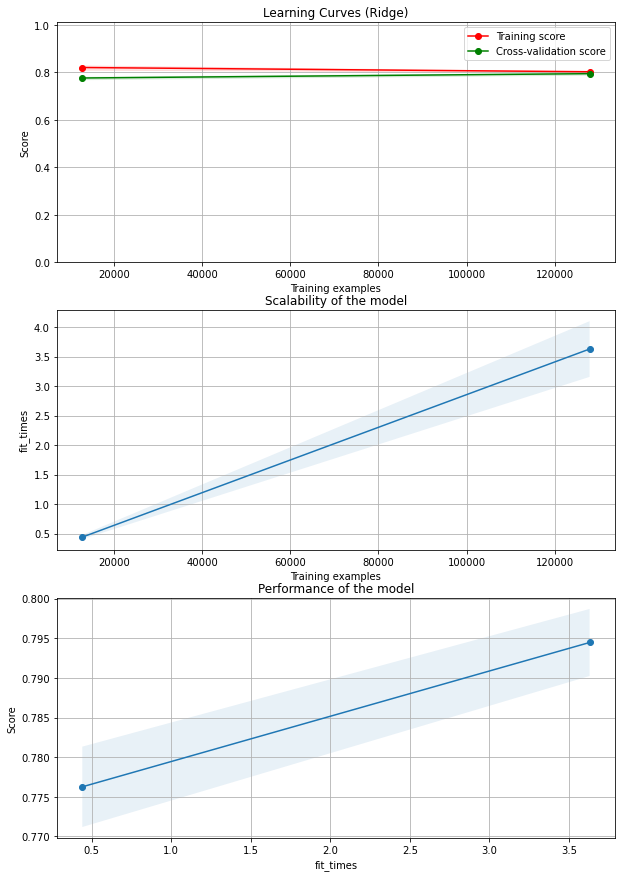

In [67]:
# Plotting Learning Curves:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 2)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv,
                       train_sizes=train_sizes,
                       return_times=True, scoring='roc_auc')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3,1, figsize=(10, 15))



title = 'Learning Curves (Ridge)'
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RidgeClassifier()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.0, 1.01),cv=cv)






plt.show()

### Random Forest Classfier

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import time
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt


def train_roc_plot(X,y,clf):
    s=time.time()
    
    # Creating train and data set:
    X_train, X_test,y_train,y_test=train_test_split(X,y,random_state=0)
    
    # Creating pipeline for MinMaxScaler and classifier:
    pipe=Pipeline([('scaler',MinMaxScaler()), ('clf',clf)])
        
    #param_grid={clf_C:[0.0001,0.001,0.1,10,1000]}
    param_grid = dict(clf__n_estimators=[50,100,150,200,300],clf__max_features=['auto','log2'])
    
    # Since we have a unbalanced sample, auc works beter to find the best model
    grid=GridSearchCV(pipe,param_grid, cv=5,n_jobs=-1,scoring='roc_auc')
    grid.fit(X_train,y_train)
    predictions=grid.predict(X_test)
    
    
    print('Accuracy test set: \n{:.3}' .format(grid.score(X_test,y_test)))
    print('Best parameter setting: \n{}' .format(grid.best_params_))
    
    
    # Confusion Matrix:
    confusion=confusion_matrix(y_test,predictions)
    print('\n\n')
    print('Confusion matrix: \n{}'.format(confusion))
    scores=grid.predict_proba(X_test)

    # ROC plotting
    fpr, tpr, _ = roc_curve(y_test, scores[:,1])

    roc_auc=auc(fpr, tpr)

    print('ROC_AUC: \n{:.2f}' .format(roc_auc))
    print('\n\n')
    plt.figure(figsize=(8,8))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, lw=3, label='Random Forest ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()
    
    e=time.time()
        
    print('Time of processing(Minutes) : \n{}'.format((e-s)/60))
    
    
    from sklearn.metrics import classification_report
    print(classification_report(y_test, predictions, target_names=['no compliance', 'compliance']))
    results=pd.DataFrame(grid.cv_results_)
    
    #columns=['param_clf__n_estimators','param_clf__max_features','mean_test_score']
    
    #scores=results[columns].pivot(index='param_clf__n_estimators',columns='param_clf__max_features', values='mean_test_score').to_numpy()

    
    #plt.figure()
    #sns.heatmap(scores.reshape(len(param_grid['param_clf__n_estimators']),len(param_grid['param_clf__max_features'])), xticklabels=['l2'], yticklabels=[0.0001, 0.001,0.01])
    #plt.yticks(rotation=0);

    print('Time of processing(Minutes) : \n{}'.format((e-s)/60))

Accuracy test set: 
0.811
Best parameter setting: 
{'clf__max_features': 'auto', 'clf__n_estimators': 300}



Confusion matrix: 
[[36469   609]
 [ 1861  1031]]
ROC_AUC: 
0.81





<IPython.core.display.Javascript object>


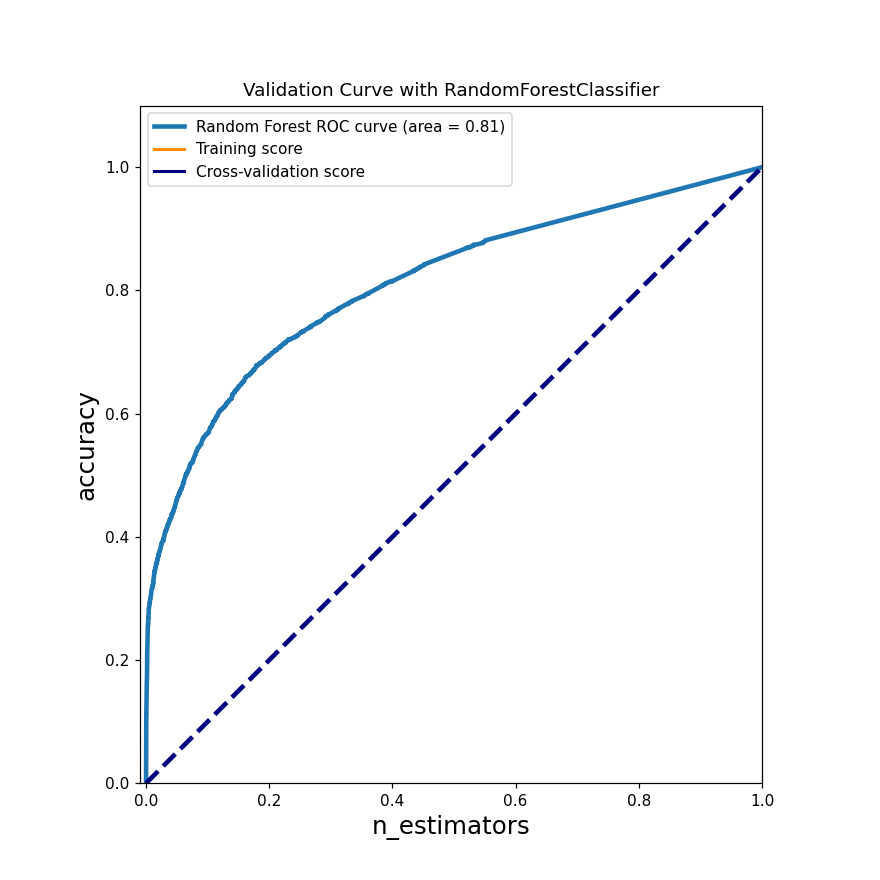

C:\Users\Sepehr\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Time of processing(Minutes) : 
26.87945227622986
               precision    recall  f1-score   support

no compliance       0.95      0.98      0.97     37078
   compliance       0.63      0.36      0.45      2892

     accuracy                           0.94     39970
    macro avg       0.79      0.67      0.71     39970
 weighted avg       0.93      0.94      0.93     39970

Time of processing(Minutes) : 
26.87945227622986


In [73]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
train_roc_plot(X,y,clf)

#### Checking for Overfitting or Underfitting:

In [74]:
# Checking for Overfitting or Underfitting:
# Plotting Validation Curves:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier

param_range=[20,50,400,800]
#ridge=Ridge()
train_scores, test_scores = validation_curve(RandomForestClassifier(), X, y, param_name="n_estimators",
param_range=param_range,cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with RandomForestClassifier')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


<IPython.core.display.Javascript object>


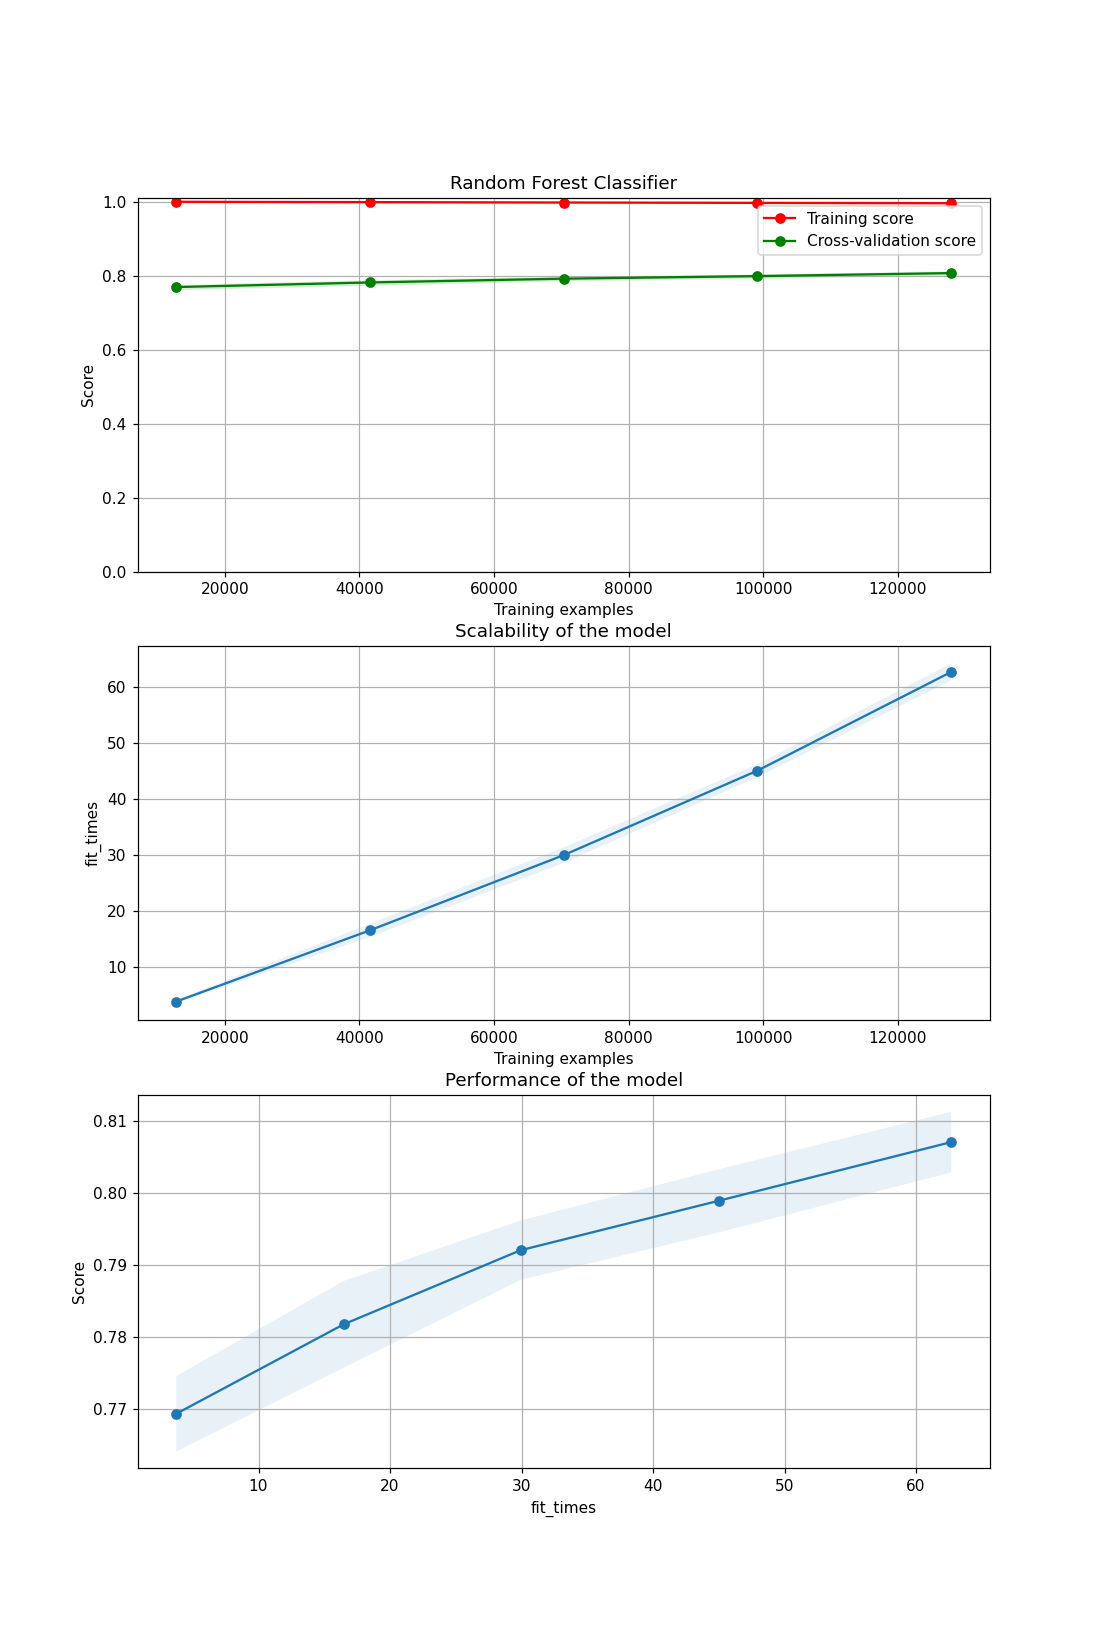

In [75]:
# Plotting Learning Curves:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv,
                       train_sizes=train_sizes,
                       return_times=True, scoring='roc_auc')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(10, 15))



title = 'Random Forest Classifier'
RandomForestClassifier

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.0, 1.01),cv=cv)


plt.show()

# Handeling unbalanced data set

### Synthetic Minority Oversampling Technique (SMOTE)

Since the process is very time consuming and with the resampling startegy, the size of data set is even larger, 
 only simple Decision tree will be run on both resampled data set and original datasets to compare the effect of resampling


In [41]:
# Run decision tree on unbalanced original dataset
clf = DecisionTreeClassifier(max_depth=5,min_samples_leaf=20)
clf = cross_val_score(clf,X,y,cv=5,scoring='f1_macro')
print('F1 Score Mean-unbalanced dataset:',clf.mean())
print('F1 Score StD-unbalanced dataset:',clf.std())


F1 Score Mean-unbalanced dataset: 0.6557942637817985
F1 Score StD-unbalanced dataset: 0.06572248679245107


In [42]:
import imblearn
print(imblearn.__version__)

0.7.0


In [43]:
# SMOTE resampling
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
# transform the dataset
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

clf = DecisionTreeClassifier(max_depth=5,min_samples_leaf=20)
clf_smote = cross_val_score(clf,X_resampled,y_resampled,cv=5,scoring='f1_macro')
print('F1 Score Mean-SMOTE:',clf_smote.mean())
print('F1 Score StD-SMOTE:',clf_smote.std())


F1 Score Mean-SMOTE: 0.784988116916789
F1 Score StD-SMOTE: 0.03024509057761806


### ADASYN: Adaptive synthetic sampling approach

In [44]:
# ADASYN resampling
# transform the dataset
X_resampled, y_resampled = ADASYN().fit_resample(X, y)
clf = DecisionTreeClassifier(max_depth=5,min_samples_leaf=20)
clf_adasyn = cross_val_score(clf,X_resampled,y_resampled,cv=5,scoring='f1_macro')
print('F1 Score Mean-ADASYN:',clf_adasyn.mean())
print('F1 Score StD-ADASYN:',clf_adasyn.std())

F1 Score Mean-ADASYN: 0.7727572776183318
F1 Score StD-ADASYN: 0.02702805218097454
